In [1]:
from src.rpp import RPP
from src.graph_viz import (
        add_pos_node_attribute, add_node_attributes, plot_graphviz, plot_circuit_graphviz, create_csv_from_dataframe
    )

In [2]:
import collections

def calculate_postman_solution_stats(circuit, edge_weight_name='distance'):
    # Статистика
    summary_stats = collections.OrderedDict()

    # Расстояние
    summary_stats['distance_walked'] = sum([e[3][edge_weight_name] for e in circuit])
    summary_stats['distance_doublebacked'] = sum([e[3][edge_weight_name] for e in circuit if 'augmented' in e[3]])
    summary_stats['distance_walked_once'] = summary_stats['distance_walked'] - summary_stats['distance_doublebacked']
    summary_stats['distance_walked_optional'] = sum([e[3]['distance'] for e in circuit if e[3].get('required') == 0])
    summary_stats['distance_walked_required'] = summary_stats['distance_walked'] - summary_stats['distance_walked_optional']

    # Ребра
    summary_stats['edges_walked'] = len(circuit)
    summary_stats['edges_doublebacked'] = collections.Counter([e[3].get('augmented') for e in circuit])[True]
    summary_stats['edges_walked_once'] = summary_stats['edges_walked'] - summary_stats['edges_doublebacked']
    summary_stats['edges_walked_optional'] = collections.Counter([e[3].get('required') for e in circuit])[0]
    summary_stats['edges_walked_required'] = summary_stats['edges_walked'] - summary_stats['edges_walked_optional']

    return summary_stats

Рассмотрим пример, когда граница $\frac{3}{2}$ достигается.

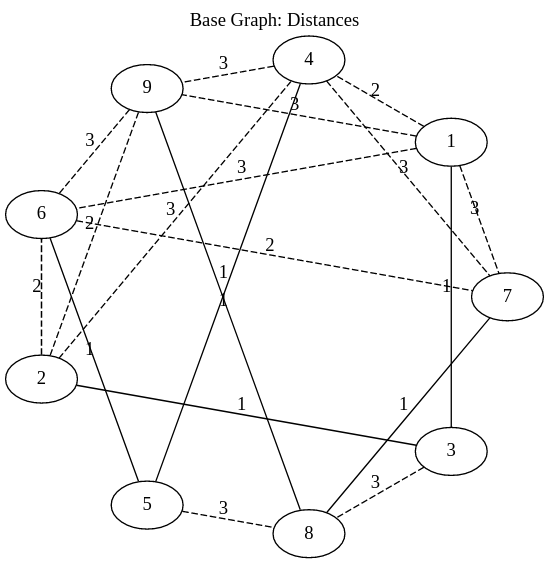

In [4]:
import networkx as nx

def create_threshold_graph(n_nodes=9, ring=True):
    """
    Граф, на котором достигается граница
    """
    graph = nx.MultiGraph()
    node_names = [i for i in range(1,n_nodes + 1)]
    graph.add_nodes_from(node_names)
    e = node_names

    nx.set_edge_attributes(graph, 1, 'distance')
    nx.set_edge_attributes(graph, 1, 'required')
    nx.set_edge_attributes(graph, 'solid', 'style')

    graph.add_edge(e[0], e[3], distance=2, required=0, style='dashed')
    graph.add_edge(e[1], e[5], distance=2, required=0, style='dashed')
    graph.add_edge(e[1], e[8], distance=2, required=0, style='dashed')
    graph.add_edge(e[5], e[6], distance=2, required=0, style='dashed')

    graph.add_edge(e[0], e[5], distance=3, required=0, style='dashed')
    graph.add_edge(e[0], e[6], distance=3, required=0, style='dashed')
    graph.add_edge(e[0], e[8], distance=3, required=0, style='dashed')
    graph.add_edge(e[1], e[3], distance=3, required=0, style='dashed')
    graph.add_edge(e[2], e[7], distance=3, required=1, style='dashed')
    graph.add_edge(e[3], e[8], distance=3, required=0, style='dashed')
    graph.add_edge(e[3], e[6], distance=3, required=0, style='dashed')
    graph.add_edge(e[4], e[7], distance=3, required=1, style='dashed')
    graph.add_edge(e[5], e[8], distance=3, required=0, style='dashed')

    graph.add_edge(e[0], e[2], distance=1, required=1, style='solid')
    graph.add_edge(e[1], e[2], distance=1, required=1, style='solid')
    graph.add_edge(e[3], e[4], distance=1, required=1, style='solid')
    graph.add_edge(e[4], e[5], distance=1, required=1, style='solid')
    graph.add_edge(e[6], e[7], distance=1, required=1, style='solid')
    graph.add_edge(e[7], e[8], distance=1, required=1, style='solid')
    return graph


START_NODE = '1'
N_NODES = 9

graph_base = create_threshold_graph(N_NODES)
edgelist = nx.to_pandas_edgelist(graph_base, source='_node1', target='_node2')

# RPP
edgelist_file = create_csv_from_dataframe(edgelist)
circuit_rpp, graph_rpp = RPP(edgelist_file, start_node=START_NODE)

for k, v in calculate_postman_solution_stats(circuit_rpp).items():
    print(k, ":", v)

# Визуализация
RPP_SVG_FILENAME = 'test1/rpp_graph'
RPP_BASE_SVG_FILENAME = 'test1/base_rpp_graph'

plot_graphviz(graph=graph_base,
              filename=RPP_BASE_SVG_FILENAME,
              edge_label_attr='distance',
              format='svg',
              engine='circo',
              graph_attr={'label': 'Base Graph: Distances', 'labelloc': 't'}
              )

plot_circuit_graphviz(circuit=circuit_rpp,
                      graph=graph_rpp,
                      filename=RPP_SVG_FILENAME,
                      format='svg',
                      engine='circo',
                      graph_attr={'label': 'Base Graph: Rural Postman Solution', 'labelloc': 't'}
                      )

distance_walked : 18
distance_doublebacked : 6
distance_walked_once : 12
distance_walked_optional : 2
distance_walked_required : 16
edges_walked : 13
edges_doublebacked : 5
edges_walked_once : 8
edges_walked_optional : 1
edges_walked_required : 12


'Plot written to test1/rpp_graph'

Алгоритм нашел цикл веса 18 (distance walked), хотя можно составить цикл веса 12. Таким образом, граница достигается.

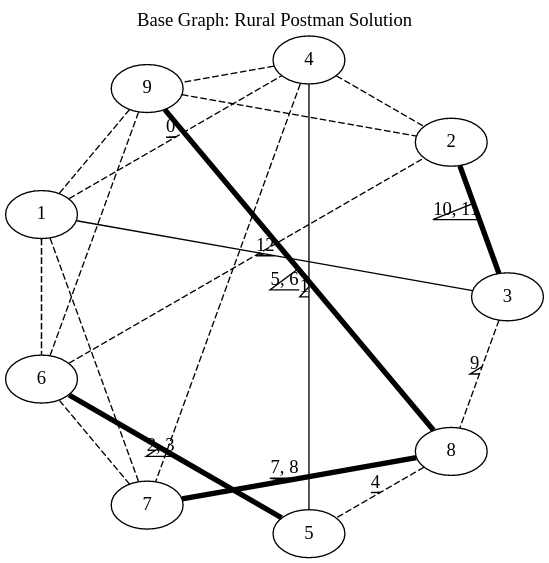

Протестируем алгоритм RPP на графе огромного реального парка. Ребра на графе - известные тропы.

In [6]:
import pandas as pd

# входные данные
EDGELIST = 'test2/edgelist_giant.csv'
NODELIST = 'test2/nodelist_giant.csv'
START_NODE = "b_end_east"

# RPP
circuit, graph = RPP(EDGELIST, START_NODE)
for k, v in calculate_postman_solution_stats(circuit).items():
    print(k, ":", v)

# Визуализация
nodelist_df = pd.read_csv(NODELIST)
graph = add_node_attributes(graph, nodelist_df)
graph = add_pos_node_attribute(graph, origin='topleft')

for e in graph.edges(data=True, keys=True):
    graph[e[0]][e[1]][e[2]]['style'] = 'solid' if graph[e[0]][e[1]][e[2]]['required'] else 'dashed'

GRAPH_ATTR = {'dpi': '65'}
EDGE_ATTR = {'fontsize': '20'}
NODE_ATTR = {'shape': 'point', 'color': 'black', 'width': '0.1', 'fixedsize': 'true'}

RPP_SVG_FILENAME = 'test2/rpp_graph'

plot_circuit_graphviz(circuit=circuit,
                      graph=graph,
                      filename=RPP_SVG_FILENAME,
                      format='svg',
                      engine='neato',
                      graph_attr=GRAPH_ATTR,
                      edge_attr=EDGE_ATTR,
                      node_attr=NODE_ATTR
                      )

distance_walked : 32.119999999999976
distance_doublebacked : 6.11
distance_walked_once : 26.009999999999977
distance_walked_optional : 0.68
distance_walked_required : 31.439999999999976
edges_walked : 151
edges_doublebacked : 30
edges_walked_once : 121
edges_walked_optional : 2
edges_walked_required : 149


'Plot written to test2/rpp_graph'

Как видно из статистики, алгоритм прошел по 151 ребру, 149 из которых обязательные, по 30 ребрам прошел дважды.

Визуализируем путь: числа на ребрах - порядок ребра при обходе.

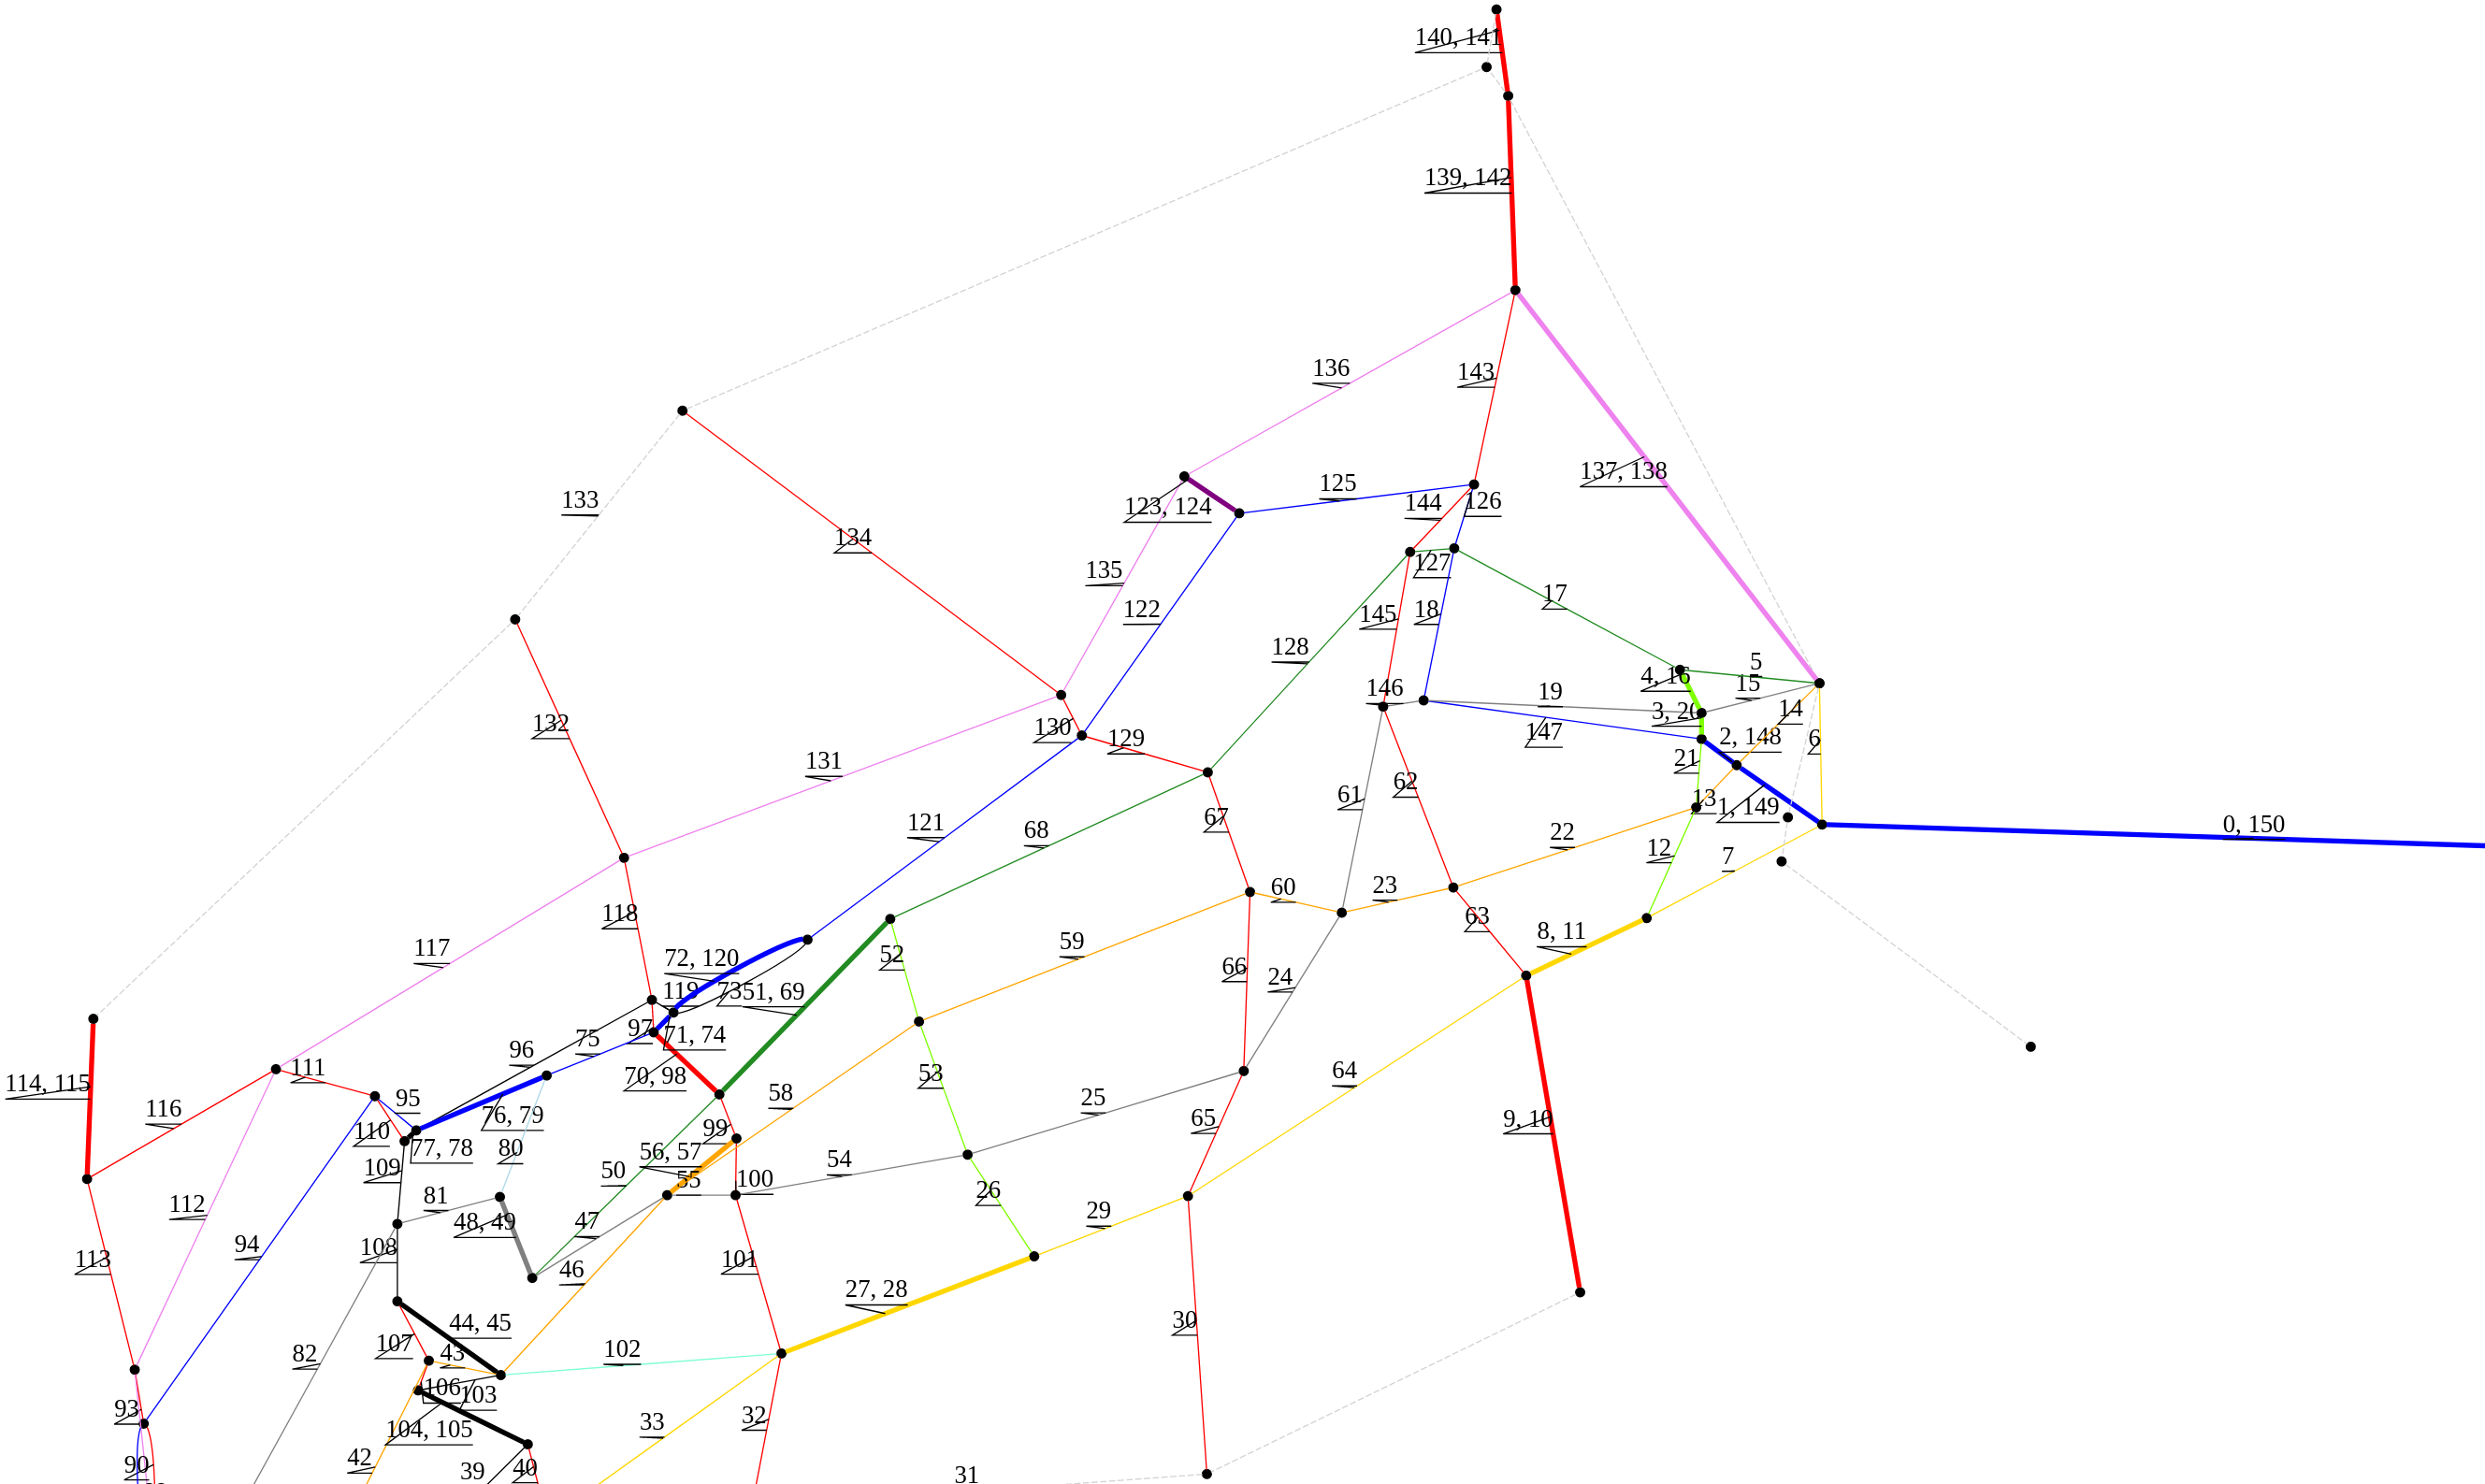